### PACKAGES, OPTIONS, CONSTANTS

In [1]:
import os

import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

### DATA LOAD

In [2]:
filename = 'CMBD_6_20181217-135856.xlsx'
path = os.path.join('..', 'data', 'external', filename)
raw_df = pd.read_excel(path)

### DATA WRANGLING

In [3]:
date_cols = ['Fecha de ingreso', 'Fecha de alta']
keep_cols = ['Sexo', 'Edad', 'Diagnóstico Principal', 'Estancia', 'Coste']

for col in date_cols:
    """
    Dates are codified as integer in DDMMYYYY format, so there's no padding zero if day < 10, i.e:
      28042013 -> 2013-04-28
       7022013 -> 2013-02-07
    """
    raw_df[col + ' new'] = pd.to_datetime(raw_df[col].map(lambda col: str(col).zfill(8)), format='%d%m%Y', errors = 'coerce')

interim_df = raw_df[keep_cols].copy()

for col in date_cols:
    interim_df[col] = raw_df[col + ' new'].copy()
    
# Ingresos y altas by date
ingresos_diarios_df = interim_df.groupby(['Fecha de ingreso']).size().reset_index(name = 'Ingresos')
ingresos_diarios_df.set_index('Fecha de ingreso', inplace = True)
ingresos_diarios_df.index.names = ['Fecha']

altas_diarias_df = interim_df.groupby(['Fecha de alta']).size().reset_index(name = 'Altas')
altas_diarias_df.set_index('Fecha de alta', inplace = True)
altas_diarias_df.index.names = ['Fecha']

# Join by date, cumsum
hospitalizaciones_df = altas_diarias_df.join(ingresos_diarios_df, how= 'outer')
hospitalizaciones_df['Ingresos acumulados'] = hospitalizaciones_df['Ingresos'].cumsum()
hospitalizaciones_df['Altas acumuladas'] = hospitalizaciones_df['Altas'].cumsum()
hospitalizaciones_df['Ocupacion'] = hospitalizaciones_df['Ingresos acumulados'] - hospitalizaciones_df['Altas acumuladas']

# Export to csv
hospitalizaciones_df.to_csv(os.path.join('..', 'data', 'processed', 'hospitalizaciones'))

### EDA

In [4]:
raw_df.head()

,Año,Hospital Recodificado,Comunidad Autónoma,Provincia,Grupo Hospital,Grupo Cluster,Historia Recodificada,CIP Recodificado,Fecha de nacimiento,Sexo,Provincia Residencia,Régimen Financiación,Fecha de ingreso,Tipo Ingreso,Fecha de alta,Tipo Alta,Estancia,Diagnóstico Principal,Diagnóstico 2,Diagnóstico 3,Diagnóstico 4,Diagnóstico 5,Diagnóstico 6,Diagnóstico 7,Diagnóstico 8,Diagnóstico 9,Diagnóstico 10,Diagnóstico 11,Diagnóstico 12,Diagnóstico 13,Diagnóstico 14,Fecha de Intervención,Procedimiento 1,Procedimiento 2,Procedimiento 3,Procedimiento 4,Procedimiento 5,Procedimiento 6,Procedimiento 7,Procedimiento 8,Procedimiento 9,Procedimiento 10,Procedimiento 11,Procedimiento 12,Procedimiento 13,Procedimiento 14,Procedimiento 15,Procedimiento 16,Procedimiento 17,Procedimiento 18,Procedimiento 19,Procedimiento 20,GDR AP,CDM AP,Tipo GDR AP,Valor Peso Español,GDR APR,CDM APR,Tipo GDR APR,Valor Peso Americano APR,Nivel Severidad,Nivel Mortalidad,Servicio,Edad,Reingreso,Coste,Fecha de ingreso new,Fecha de alta new
0,2013,-398345888794880068,13,28,4,4,-1687781257578748014,-320943158-171303395,10041944,1,28,1,30102013,1,13112013,1,14,428.0,NaN,276.1,276.8,491.20,494.0,041.85,518.83,401.9,427.31,553.3,V43.4,V15.82,V58.61,NaN,39.96,99.21,93.96,89.39,90.59,91.39,90.42,89.65,87.44,89.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544,5,M,0.9181,194,5,M,1.0551,3,2,NML,69,1,4441.45,2013-10-30,2013-11-13
1,2013,-3959599681650518086,13,28,3,4,166370745435838543,648485069584850511,10061937,1,28,1,19032013,1,25032013,1,6,491.21,NaN,518.84,519.8,305.1,V15.05,V46.2,600.00,V60.3,V15.82,NaN,NaN,NaN,NaN,NaN,90.42,87.44,87.44,89.52,89.65,89.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541,4,M,0.9407,140,4,M,0.9057,3,3,NML,75,0,4550.50,2013-03-19,2013-03-25
2,2013,-3959599681650518086,13,28,3,4,183632305468848809,899288196-1988273609,14111923,1,28,1,15112013,1,26112013,1,11,428.0,NaN,518.84,584.9,516.8,491.22,585.9,416.8,403.90,250.00,427.31,274.9,426.4,600.00,NaN,90.42,87.44,87.44,89.52,89.65,88.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544,5,M,0.9181,194,5,M,2.2623,4,4,NML,90,0,4441.45,2013-11-15,2013-11-26
3,2013,-1468647043-245326524,13,28,4,5,2877111881585847151,-961279109-1723117644,10051956,2,28,1,28042013,1,14052013,1,16,428.1,NaN,428.20,518.81,491.20,305.1,416.8,276.2,424.2,414.10,NaN,NaN,NaN,NaN,NaN,88.72,87.44,89.37,89.17,89.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544,5,M,0.9181,194,5,M,1.0551,3,4,NML,56,0,4441.45,2013-04-28,2013-05-14
4,2013,946141513-1168024764,13,28,3,3,17519509571482774643,-33451060035352825,7091928,1,28,1,7022013,2,8022013,1,1,162.5,NaN,496,173.9,600.90,414.8,414.01,250.00,272.0,401.9,V15.82,V45.81,V45.61,V10.83,NaN,33.26,33.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,4,M,0.9844,136,4,M,0.8844,2,2,NML,84,0,4761.87,2013-02-07,2013-02-08


In [5]:
interim_df.head()

,Sexo,Edad,Diagnóstico Principal,Estancia,Coste,Fecha de ingreso,Fecha de alta
0,1,69,428.0,14,4441.45,2013-10-30,2013-11-13
1,1,75,491.21,6,4550.50,2013-03-19,2013-03-25
2,1,90,428.0,11,4441.45,2013-11-15,2013-11-26
3,2,56,428.1,16,4441.45,2013-04-28,2013-05-14
4,1,84,162.5,1,4761.87,2013-02-07,2013-02-08


In [6]:
interim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140937 entries, 0 to 140936
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Sexo                   140937 non-null  int64         
 1   Edad                   140937 non-null  int64         
 2   Diagnóstico Principal  140937 non-null  object        
 3   Estancia               140937 non-null  int64         
 4   Coste                  140937 non-null  float64       
 5   Fecha de ingreso       140937 non-null  datetime64[ns]
 6   Fecha de alta          140937 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
interim_df.describe(include = 'all', datetime_is_numeric=True)

,Sexo,Edad,Diagnóstico Principal,Estancia,Coste,Fecha de ingreso,Fecha de alta
count,140937.000000,140937.000000,140937,140937.000000,140937.000000,140937,140937
unique,NaN,NaN,1714,NaN,NaN,NaN,NaN
top,NaN,NaN,491.21,NaN,NaN,NaN,NaN
freq,NaN,NaN,22080,NaN,NaN,NaN,NaN
mean,1.385640,66.232373,NaN,8.233792,4326.082895,2011-12-16 14:29:22.949431296,2011-12-24 20:06:02.613079040
min,1.000000,0.000000,NaN,0.000000,0.000000,2007-08-02 00:00:00,2008-01-01 00:00:00
25%,1.000000,57.000000,NaN,3.000000,3020.730000,2010-01-15 00:00:00,2010-01-25 00:00:00
50%,1.000000,70.000000,NaN,6.000000,4040.280000,2011-12-27 00:00:00,2012-01-03 00:00:00
75%,2.000000,79.000000,NaN,10.000000,4584.570000,2013-11-20 00:00:00,2013-11-28 00:00:00
max,3.000000,110.000000,NaN,623.000000,116051.540000,2015-12-30 00:00:00,2015-12-31 00:00:00


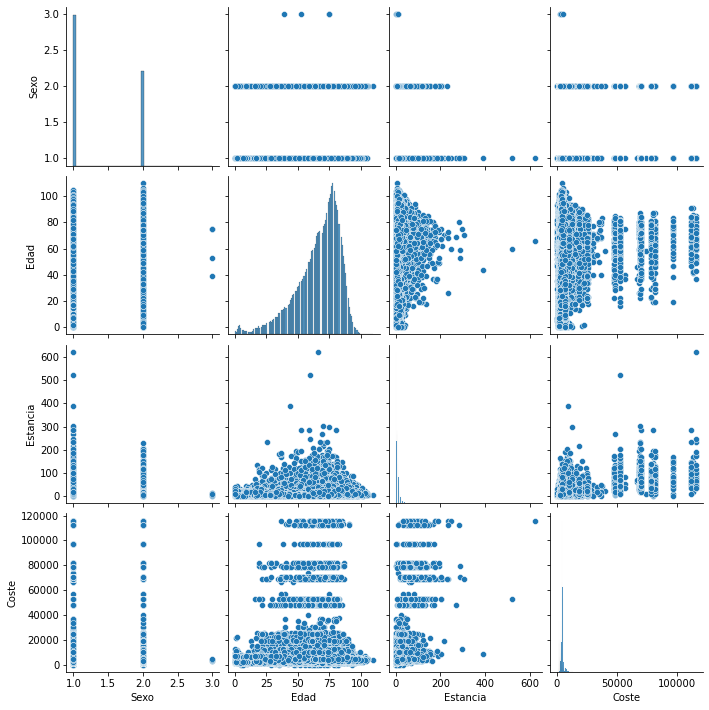

In [8]:
sns.pairplot(interim_df);

In [9]:
hospitalizaciones_df

,Altas,Ingresos,Ingresos acumulados,Altas acumuladas,Ocupacion
Fecha,,,,,
2007-08-02,NaN,1.0,1.0,NaN,NaN
2007-08-20,NaN,1.0,2.0,NaN,NaN
2007-09-20,NaN,2.0,4.0,NaN,NaN
2007-09-29,NaN,1.0,5.0,NaN,NaN
2007-10-22,NaN,1.0,6.0,NaN,NaN
...,...,...,...,...,...
2015-12-27,4.0,26.0,140891.0,140638.0,253.0
2015-12-28,60.0,37.0,140928.0,140698.0,230.0
2015-12-29,71.0,7.0,140935.0,140769.0,166.0


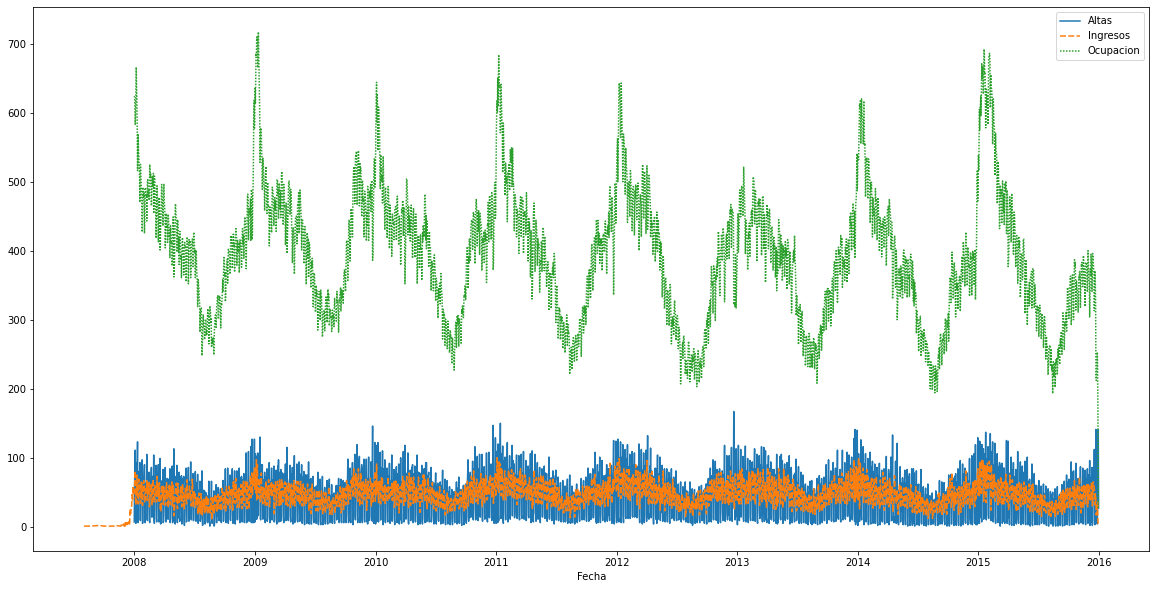

In [10]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

plot_cols = ['Altas','Ingresos','Ocupacion']
sns.lineplot(data=hospitalizaciones_df[plot_cols], ax = ax);